# GNSS-R 土壤湿度 EnKF 模拟

依次运行本笔记本即可：
- 构建季节性气象强迫并生成“真实”土壤湿度/植被含水量状态；
- 通过 Mironov 介电模型 + 植被衰减的 GNSS-R 观测算子生成反射率；
- 使用集合卡尔曼滤波器完成同化并评估误差；
- 绘制土壤湿度与观测对比图。

In [12]:
from __future__ import annotations

import math
import os
import sys
from dataclasses import asdict
from pathlib import Path

# 避免受限环境下的并行库共享内存问题
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('MKL_THREADING_LAYER', 'SEQUENTIAL')
os.environ.setdefault('MKL_SERVICE_FORCE_INTEL', '1')

notebook_dir = Path.cwd()
for candidate in (notebook_dir, notebook_dir / 'src', notebook_dir.parent / 'src'):
    if (candidate / 'ProcessModel.py').exists():
        module_dir = candidate.resolve()
        break
else:
    module_dir = notebook_dir.resolve()

if str(module_dir) not in sys.path:
    sys.path.append(str(module_dir))

import numpy as np
import matplotlib.pyplot as plt

from ProcessModel import ForcingInputs, ProcessModel
from ObservationModel import ObservationModel, ObservationParams
from EnsembleKalmanFilter import EnsembleKalmanFilter

In [13]:
def generate_forcings(num_steps: int, seed: int = 7) -> list[ForcingInputs]:
    rng = np.random.default_rng(seed)
    forcings: list[ForcingInputs] = []
    doy0 = 120
    for k in range(num_steps):
        doy = (doy0 + k) % 365 + 1
        seasonal = math.sin(2.0 * math.pi * (doy - 80) / 365.0)
        precipitation = max(0.0, 2.0 + 4.0 * seasonal + rng.normal(0.0, 1.5))
        pet = max(0.5, 3.5 + 1.0 * seasonal + rng.normal(0.0, 0.3))
        temperature = 18.0 + 10.0 * seasonal + rng.normal(0.0, 1.5)
        forcings.append(
            ForcingInputs(
                precipitation=precipitation,
                pet=pet,
                temperature=temperature,
                doy=doy,
            )
        )
    return forcings


def create_truth(
    process_model: ProcessModel,
    observation_model: ObservationModel,
    forcings: list[ForcingInputs],
    process_noise_std: np.ndarray,
    obs_params: ObservationParams,
    seed: int = 42,
):
    rng = np.random.default_rng(seed)
    num_steps = len(forcings)
    truth_states = np.zeros((num_steps, 2))
    reflectivity = np.zeros(num_steps)

    state = np.array([0.25, 1.2])
    for idx, forcing in enumerate(forcings):
        state = process_model.run(state, forcing)
        state += rng.normal(0.0, process_noise_std)
        state[0] = np.clip(state[0], 0.0, process_model.sm_sat)
        state[1] = np.clip(state[1], 0.0, process_model.vwc_max)
        truth_states[idx] = state
        reflectivity[idx] = observation_model.run(state, obs_params)

    return truth_states, reflectivity


def run_experiment(num_steps: int = 120) -> dict[str, np.ndarray]:
    process_model = ProcessModel()
    observation_model = ObservationModel(sand_fraction=0.45, clay_fraction=0.25)

    forcings = generate_forcings(num_steps=num_steps)
    obs_params = ObservationParams(
        incidence_angle_deg=40.0,
        surface_rms_height_m=0.015,
        vegetation_b=0.12,
        temperature_kelvin=295.0,
    )

    truth_states, truth_reflectivity = create_truth(
        process_model,
        observation_model,
        forcings,
        process_noise_std=np.array([0.01, 0.1]),
        obs_params=obs_params,
    )

    observation_noise_std = 0.01
    observations = truth_reflectivity + np.random.normal(
        0.0, observation_noise_std, size=len(truth_reflectivity)
    )

    enkf = EnsembleKalmanFilter(process_model, observation_model, ensemble_size=80)
    enkf.initialize(initial_mean=[0.20, 0.8], initial_cov=np.diag([0.02**2, 0.4**2]))

    q = np.diag([0.015**2, 0.15**2])
    r = np.array([[observation_noise_std**2]])

    analysis = np.zeros_like(truth_states)
    forecast = np.zeros_like(truth_states)

    for idx, forcing in enumerate(forcings):
        enkf.forecast(asdict(forcing), q)
        forecast[idx] = enkf.state_estimate
        enkf.analysis(observations[idx], r, asdict(obs_params))
        analysis[idx] = enkf.state_estimate

    return {
        'truth': truth_states,
        'forecast': forecast,
        'analysis': analysis,
        'observations': observations,
        'reflectivity_truth': truth_reflectivity,
    }


def summarize_results(results: dict[str, np.ndarray]) -> None:
    truth = results['truth']
    analysis = results['analysis']
    forecast = results['forecast']

    sm_mae = float(np.mean(np.abs(analysis[:, 0] - truth[:, 0])))
    vwc_mae = float(np.mean(np.abs(analysis[:, 1] - truth[:, 1])))

    print('Final truth state          :', truth[-1])
    print('Final EnKF analysis state  :', analysis[-1])
    print('Final EnKF forecast state  :', forecast[-1])
    print('Mean absolute SM error (m3/m3):', sm_mae)
    print('Mean absolute VWC error (kg/m2):', vwc_mae)


def plot_results(results: dict[str, np.ndarray]) -> None:
    truth = results['truth']
    forecast = results['forecast']
    analysis = results['analysis']
    observations = results['observations']
    reflectivity_truth = results['reflectivity_truth']

    time = np.arange(truth.shape[0])

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ax1.plot(time, truth[:, 0], 'k-', label='Truth SM', linewidth=2.5)
    ax1.plot(time, forecast[:, 0], 'r--', label='Forecast SM', linewidth=2)
    ax1.plot(time, analysis[:, 0], 'b-', label='EnKF Analysis SM', linewidth=2)
    ax1.set_ylabel('SM (m³/m³)')
    ax1.set_title('Soil Moisture Assimilation Results')
    ax1.legend(loc='upper right')

    ax2.plot(time, reflectivity_truth, 'k-', label='Truth Reflectivity', linewidth=2.0)
    ax2.plot(time, observations, 'go', label='Observed (with noise)', markersize=4, alpha=0.7)
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Reflectivity (unitless)')
    ax2.set_title('GNSS-R Reflectivity')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()

In [14]:
results = run_experiment()
summarize_results(results)

Final truth state          : [0.23688287 1.89103971]
Final EnKF analysis state  : [0.27050769 2.04277397]
Final EnKF forecast state  : [0.27100538 2.015496  ]
Mean absolute SM error (m3/m3): 0.014640305523235472
Mean absolute VWC error (kg/m2): 0.07881688840636038


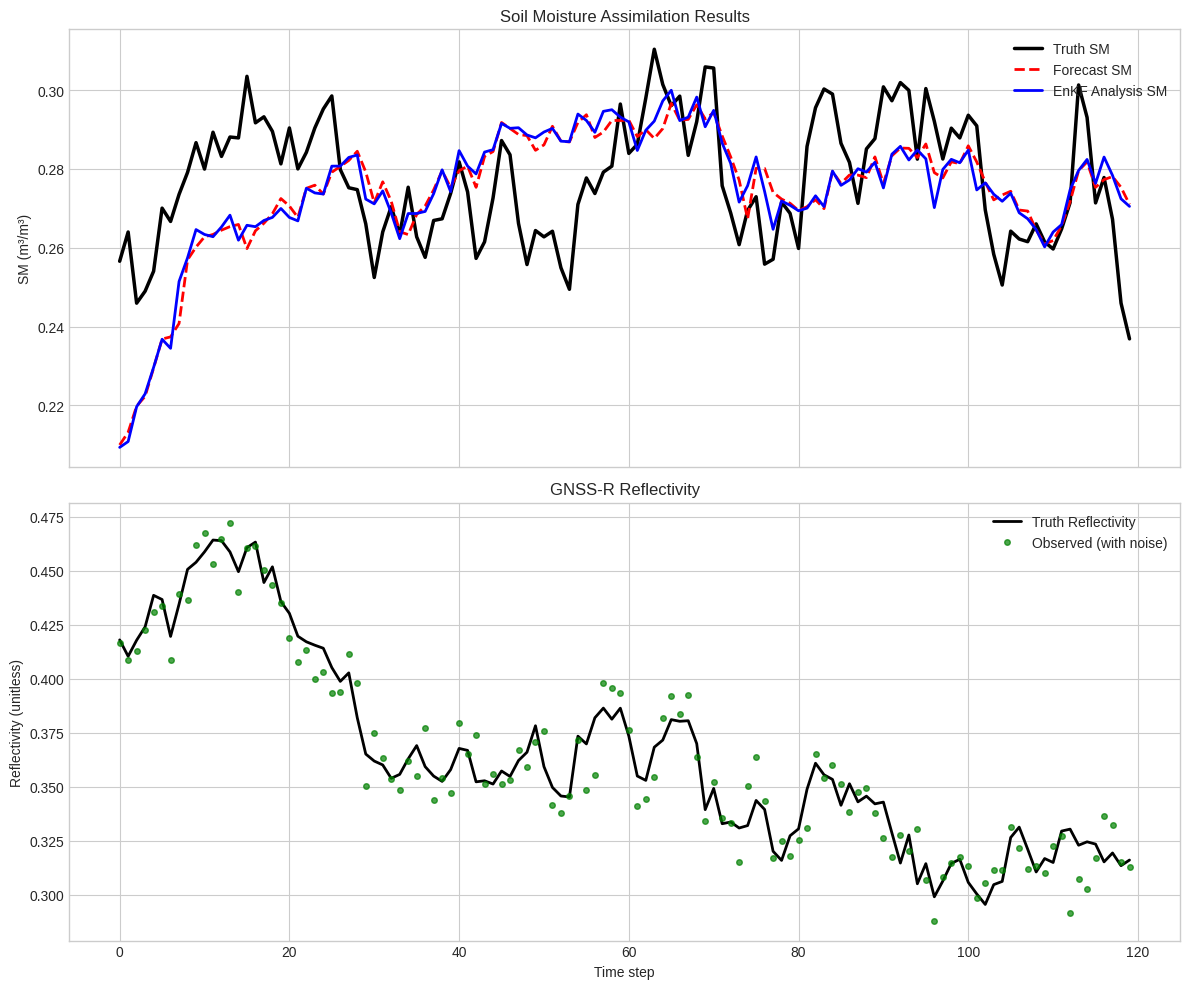

In [15]:
plot_results(results)